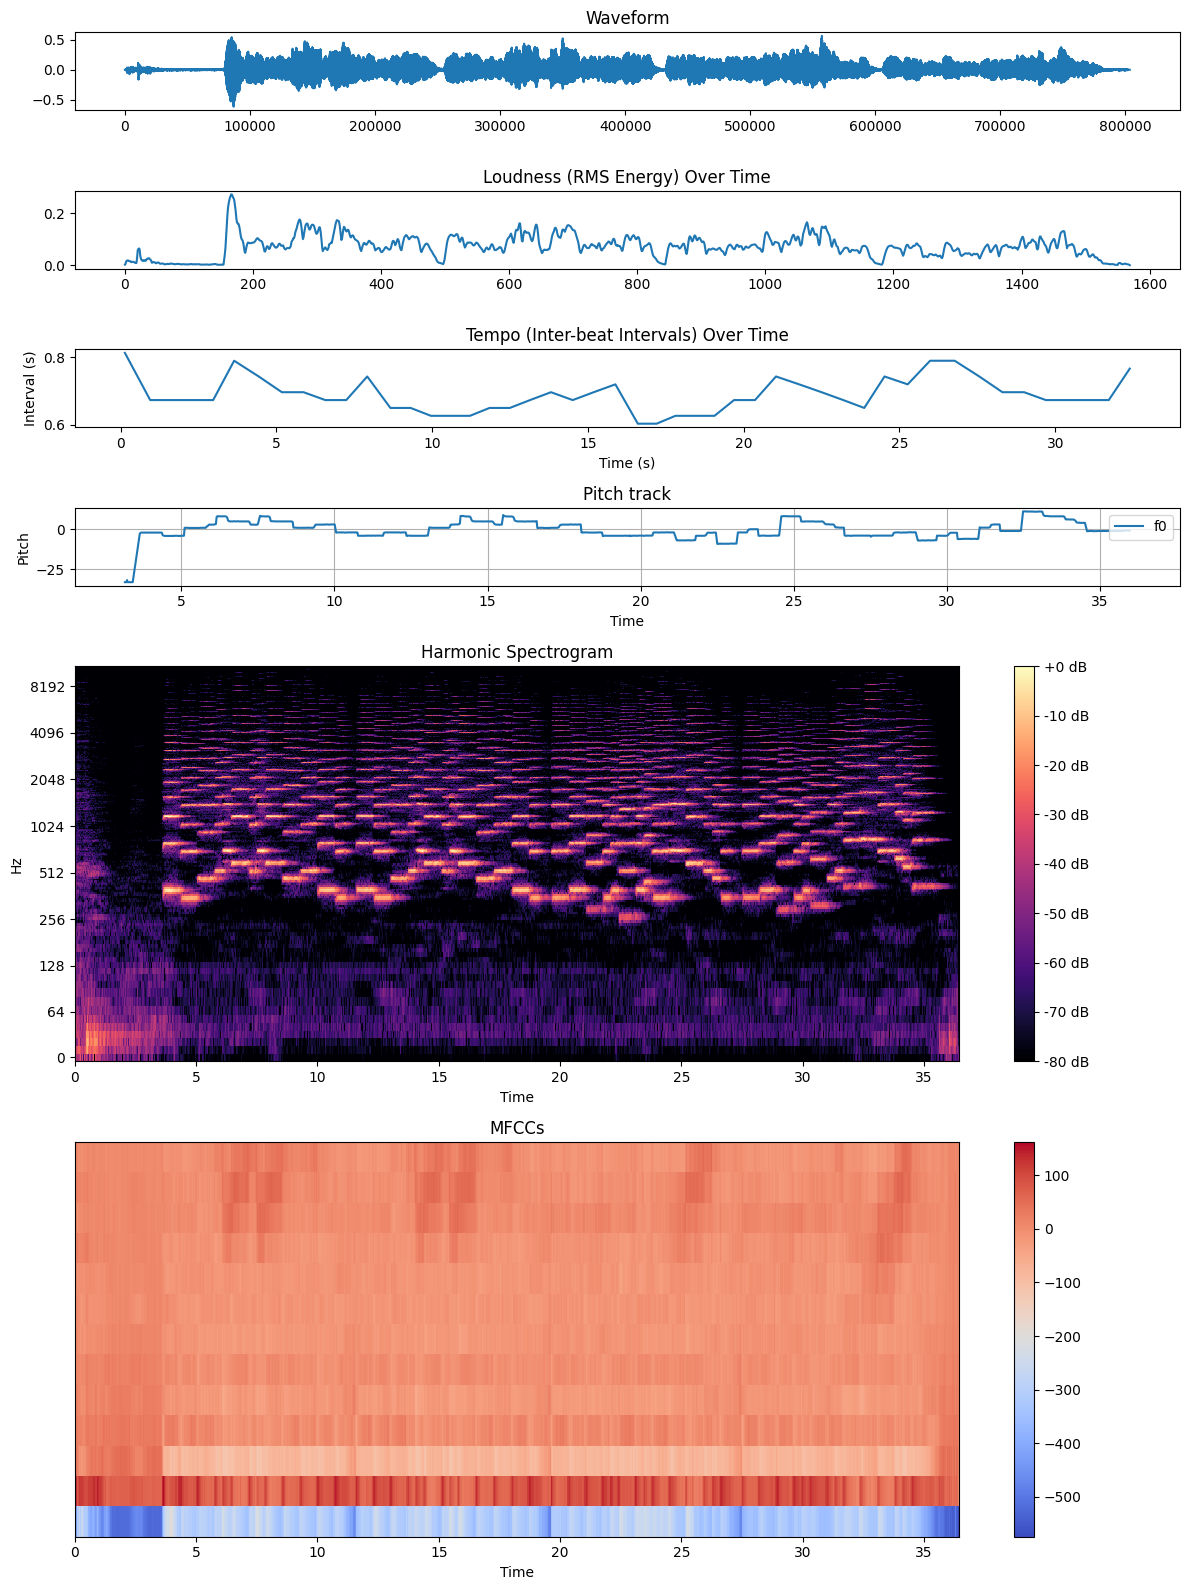

Performance scores:
*********************************
Dynamics: 0.04
Tempo: 20.15
Intonation: 0.18
Tone Quality: 34.14
Timbre: 0.05
*********************************
Total score: 10.91



In [89]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mir_eval

# Load the audio file
file_path = 'pics.mp3'
y, sr = librosa.load(file_path)

# pYIN pitch tracking
f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

# times corresponding to f0 estimates
times = librosa.times_like(f0)

# Beat tracking
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

# Beat frames to time
beat_times = librosa.frames_to_time(beats, sr=sr)

# Calculate the time difference between beats
beat_diff = np.diff(beat_times)

# Create a figure with custom size
plt.figure(figsize=(12, 16))

# Create a gridspec to layout your subplots
gs = gridspec.GridSpec(10, 1)

# Waveform
plt.subplot(gs[0, 0])
plt.plot(y)
plt.title('Waveform')

# RMS energy over time
plt.subplot(gs[1, 0])
plt.plot(librosa.feature.rms(y=y)[0])
plt.title('Loudness (RMS Energy) Over Time')

# Inter-beat intervals over time
plt.subplot(gs[2, 0])
plt.plot(beat_times[:-1], beat_diff)
plt.title('Tempo (Inter-beat Intervals) Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Interval (s)')

# Convert f0 values into musical notes
notes = mir_eval.melody.hz2cents(f0, base_frequency=442.0) / 100

# Remove unvoiced parts
notes = notes[voiced_flag]

# Filter times with voiced_flag
times_voiced = times[voiced_flag]

# Plot the pitch track
plt.subplot(gs[3, 0])
plt.plot(times_voiced, notes, label='f0')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.title('Pitch track')
plt.grid(True)

# Compute the short-time Fourier transform (STFT)
D = librosa.stft(y)

# Separate the harmonic and percussive components
H, P = librosa.decompose.hpss(D)

# Convert the magnitude spectrogram to dB-scaled spectrogram
H_db = librosa.amplitude_to_db(np.abs(H), ref=np.max)

# Display the harmonic spectrogram
plt.subplot(gs[4:7, 0])
librosa.display.specshow(H_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Harmonic Spectrogram')


# Compute MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

mfcc_std = np.std(mfccs, axis=1)

# Compute "timbre score" 
timbre_score = 1 / np.mean(mfcc_std)

# Display the MFCCs
plt.subplot(gs[7:10, 0])
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCCs')

plt.tight_layout()
plt.show()
rms = librosa.feature.rms(y=y)[0]
loudness_score = np.std(rms)
beat_diff_score = 1 / np.std(beat_diff)
pitch_score = 1 / np.std(notes)
contrast = librosa.feature.spectral_contrast(S=np.abs(H), sr=sr)
contrast_score = np.mean(contrast)

total_score = (loudness_score + beat_diff_score + pitch_score + contrast_score + timbre_score) / 5

print(f"""Performance scores:
*********************************
Dynamics: {loudness_score:.2f}
Tempo: {beat_diff_score:.2f}
Intonation: {pitch_score:.2f}
Tone Quality: {contrast_score:.2f}
Timbre: {timbre_score:.2f}
*********************************
Total score: {total_score:.2f}
""")